So first, we need to download CSV data. Now that we have it locally, we need to read the CSV file as a data frame.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import numpy as np

existing_df = pd.read_csv(
    'data/Customer-country_data_5-5.csv', 
    index_col = 0, 
    thousands  = ',')
existing_df.index.names = ['Customer']
existing_df.columns.names = ['Month']

We have specified index_col to be 0 since we want the customer names to be the row labels. We also specified the thousands separator to be ',' so Pandas automatically parses cells as numbers. We can use head() to check the first few lines.

In [2]:
existing_df.head()

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Customer,,,,,,,,,,,,
FORD MOTOR,2179445.3,2451157.8,3065549.6,2143168.8,2802872.7,2361419.9,2229297.5,2220068.0,2157691.2,4138561.4,2208379.7,3462939.3
FORD MOTOR,2683531.2,3200224.3,3361681.0,3272825.3,2214082.7,2037433.5,2417451.7,1831213.1,1711370.3,2531806.2,1374825.4,1668364.5
FORD MOTOR,1687196.1,1504163.1,1957948.6,2146484.9,2003067.8,2179836.2,1652047.3,1651120.5,1912328.7,2005023.5,0.0,0.0
FORD MOTOR,1380127.8,1155731.9,1479899.9,1419183.8,1392073.2,1388426.7,1605150.5,1447924.2,1258202.1,1319266.3,1497892.0,1122182.7
FORD MOTOR,1138654.1,1370635.3,1515229.1,1565816.5,1491096.0,924647.8,2173256.2,1542600.6,1682383.1,1663275.4,1657623.3,1542581.3


Python's sklearn machine learning library comes with a PCA implementation. This implementation uses the scipy.linalg implementation of the singular value decomposition. It only works for dense arrays (see numPy dense arrays or sparse array PCA if you are using sparse arrays) and is not scalable to large dimensional data. For large dimensional data we should consider something such as Spark's dimensionality reduction features. In our case we just have 12 variables, and that is far from being a large number of features for today's machine learning libraries and computer capabilities.

When using this implementation of PCA we need to specify in advance the number of principal components we want to use. Then we can just call the fit() method with our data frame and check the results.

In [3]:
pca = PCA(n_components=2)
pca.fit(existing_df)

PCA(copy=True, n_components=2, whiten=False)

This gives us an object we can use to transform our data by calling transform.

In [4]:
existing_2d = pca.transform(existing_df)

existing_df_2d = pd.DataFrame(existing_2d)
existing_df_2d.index = existing_df.index
existing_df_2d.columns = ['PC1','PC2']
existing_df_2d.head()

,PC1,PC2
Customer,,
FORD MOTOR,-4158806.812476,-1591410.948656
FORD MOTOR,-3409891.265879,62113.376247
FORD MOTOR,-847867.974585,1664939.298624
FORD MOTOR,121613.999759,-521347.844966
FORD MOTOR,-371757.326915,-792119.346231


Or we could have just called fit_transform to perform both steps in one single
call.

In both cases we will end up with a lower dimension representation of our data
frame, as a numPy array. Let's put it in a new data frame.

In [5]:
pca.explained_variance_ratio_

array([ 0.91827345,  0.06750738])

We see that the first PC already explains almost 93% of the variance, while the second one accounts for another 5% for a total of almost 98% between the two of them.

Now we are ready to plot the lower dimensionality version of our dataset. We just need to call plot on the data frame, by passing the kind of plot we want (see here for more on plotting data frames) and what columns correspond to each axis. We also add an annotation loop that tags every point with its customer name.

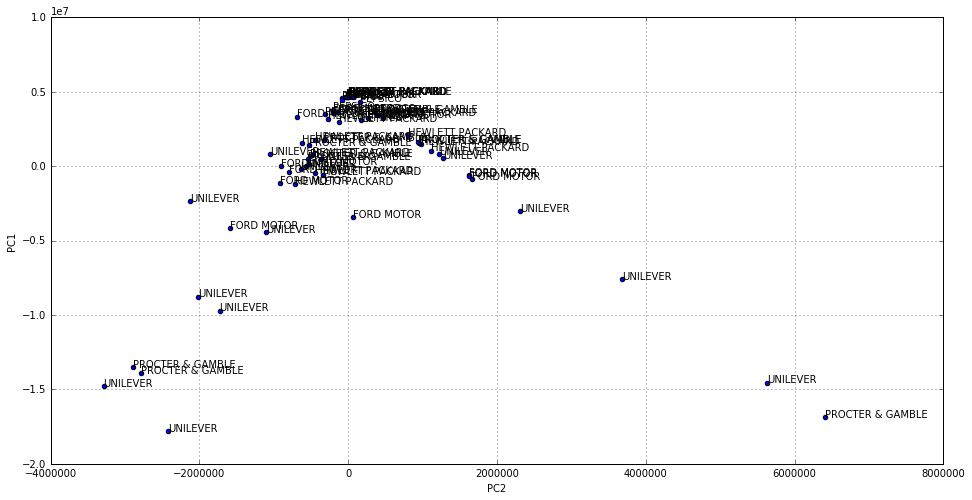

In [6]:
%matplotlib inline

ax = existing_df_2d.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))

for i, country in enumerate(existing_df.index):
    ax.annotate(
        country, 
        (existing_df_2d.iloc[i].PC2, existing_df_2d.iloc[i].PC1)
    )

In [7]:
existing_df_2d['customer_mean'] = pd.Series(existing_df.mean(axis=1), index=existing_df_2d.index)
customer_mean_max = existing_df_2d['customer_mean'].max()
customer_mean_min = existing_df_2d['customer_mean'].min()
customer_mean_scaled = (existing_df_2d.customer_mean-customer_mean_min) / customer_mean_max
existing_df_2d['customer_mean_scaled'] = pd.Series(
        customer_mean_scaled, 
        index=existing_df_2d.index) 
existing_df_2d.head()

,PC1,PC2,customer_mean,customer_mean_scaled
Customer,,,,
FORD MOTOR,-4158806.812476,-1591410.948656,2618379.266667,0.398251
FORD MOTOR,-3409891.265879,62113.376247,2358734.100000,0.358746
FORD MOTOR,-847867.974585,1664939.298624,1558268.058333,0.236953
FORD MOTOR,121613.999759,-521347.844966,1372171.758333,0.208638
FORD MOTOR,-371757.326915,-792119.346231,1522316.558333,0.231483


Let's now create a bubble chart, by setting the point size to a value proportional to the mean value for all the months in that particular customer. First we need to add a new column containing the re-scaled mean per customer across all the months.

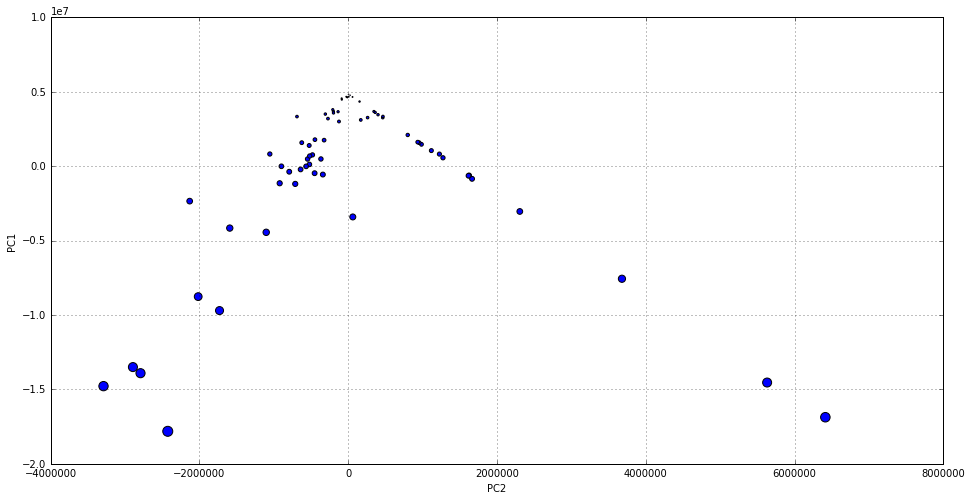

In [8]:
existing_df_2d.plot(
    kind='scatter', 
    x='PC2', 
    y='PC1', 
    s=existing_df_2d['customer_mean_scaled']*100, 
    figsize=(16,8))

Let's do the same with the sum instead of the mean.

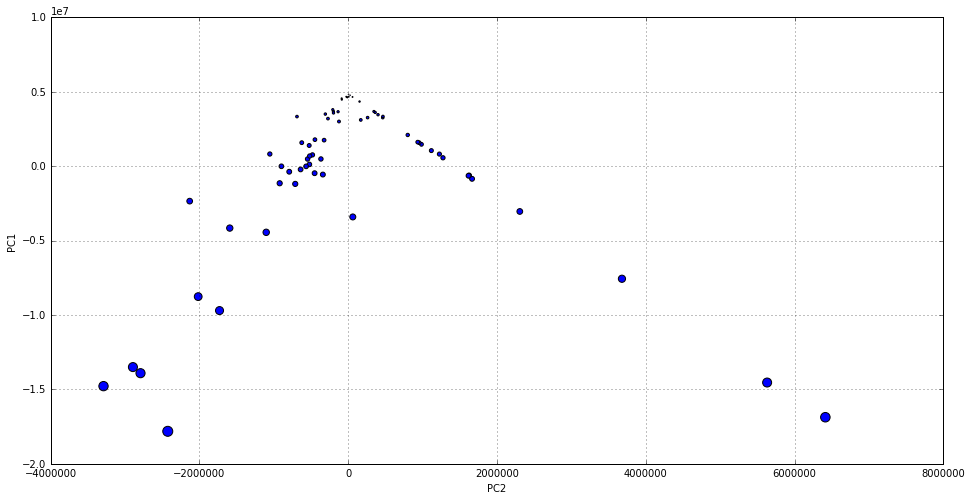

In [9]:
existing_df_2d['customer_sum'] = pd.Series(
    existing_df.sum(axis=1), 
    index=existing_df_2d.index)
customer_sum_max = existing_df_2d['customer_sum'].max()
customer_sum_min = existing_df_2d['customer_sum'].min()
customer_sum_scaled = (existing_df_2d.customer_sum-customer_sum_min) / customer_sum_max
existing_df_2d['customer_sum_scaled'] = pd.Series(
        customer_sum_scaled, 
        index=existing_df_2d.index)
existing_df_2d.plot(
    kind='scatter', 
    x='PC2', y='PC1', 
    s=existing_df_2d['customer_sum_scaled']*100, 
    figsize=(16,8))

And finally let's associate the size with the change between Jan and Dec. Note that in the scaled version, those values close to zero will make reference to those with negative values in the original non-scaled version, since we are scaling to a [0,1] range.

In [10]:
existing_df_2d['customer_change'] = pd.Series(
    existing_df['Jan']-existing_df['Dec'], 
    index=existing_df_2d.index)
customer_change_max = existing_df_2d['customer_change'].max()
customer_change_min = existing_df_2d['customer_change'].min()
customer_change_scaled = (existing_df_2d.customer_change - customer_change_min) / customer_change_max
existing_df_2d['customer_change_scaled'] = pd.Series(
        customer_change_scaled, 
        index=existing_df_2d.index)
existing_df_2d[['customer_change','customer_change_scaled']].head()

,customer_change,customer_change_scaled
Customer,,
FORD MOTOR,-1283494.0,0.017313
FORD MOTOR,1015166.7,0.371903
FORD MOTOR,1687196.1,0.475570
FORD MOTOR,257945.1,0.255094
FORD MOTOR,-403927.2,0.152994


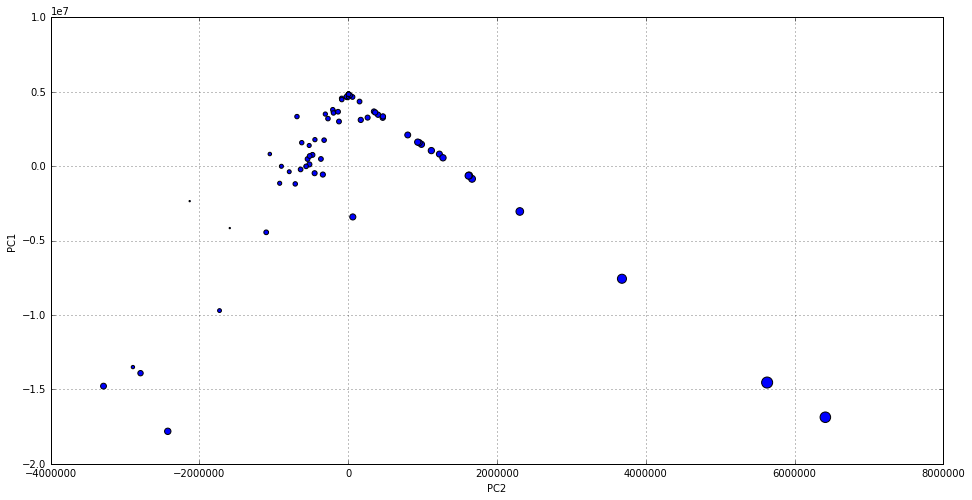

In [11]:
existing_df_2d.plot(
    kind='scatter', 
    x='PC2', y='PC1', 
    s=existing_df_2d['customer_change_scaled']*100, 
    figsize=(16,8))

Again we will use sklearn, in this case its k-means clustering implementation, in order to perform our clustering on the TB data. Since we already decided on a number of clusters of 5, we will use it here straightaway.

In [31]:
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit(existing_df)

Now we need to store the cluster assignments together with each customer in our data frame. The cluster labels are returned in clusters.labels_.

In [32]:
existing_df_2d['cluster'] = pd.Series(clusters.labels_, index=existing_df_2d.index)

And now we are ready to plot, using the cluster column as color.

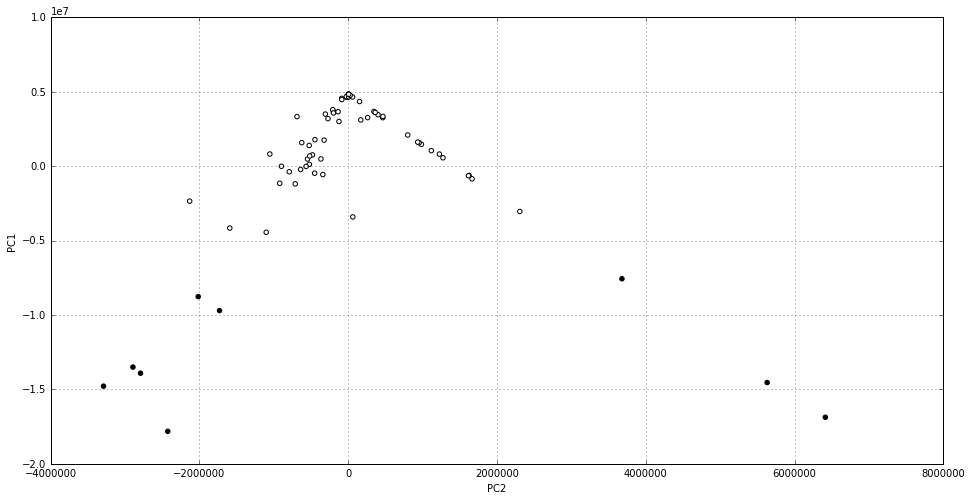

In [33]:
existing_df_2d.plot(
        kind='scatter',
        x='PC2',y='PC1',
        c=existing_df_2d.cluster.astype(np.float), 
        figsize=(16,8))

In [34]:
groups = existing_df_2d.groupby('cluster')
cluster1 = [n for n in groups.get_group(0).to_dict()['customer_sum']]
cluster2 = [n for n in groups.get_group(1).to_dict()['customer_sum']]

In [35]:
print cluster1

['PROCTER & GAMBLE', 'FORD MOTOR', 'HEWLETT PACKARD', 'UNILEVER', 'PEPSICO']


In [36]:
print cluster2

['PROCTER & GAMBLE', 'UNILEVER']
